<a href="https://colab.research.google.com/github/Arabyan/DataCamp-Homeworks/blob/master/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries, preparing to spark dataframe, processing the data

In [7]:
!pip install pyspark
from pyspark.sql import SparkSession
from IPython.display import display
from pyspark.sql.functions import col, count, asc, desc, when ,\
concat_ws, length, avg, round, median, sum


import pandas as pd

# Create a Spark session
spark = SparkSession.builder.appName("CSVReader").getOrCreate()

# Read the CSV file from the current directory
file_path = "train.csv"  # Make sure the file is in the current working directory
column_heads = ["Sport", "Kitchen", "Cook"]
df = spark.read.csv(file_path, header=False, inferSchema=True)

# Show the contents of the DataFrame


# Stop the Spark session
# spark.stop()
# In the code above, we use spark.read.csv to read the CSV file named "train.csv" from the current directory. The header=True argument indicates that the first row of the CSV file contains the header names, and the inferSchema=True argument attempts to automatically infer the data types of columns.

# Make sure that the "train.csv" file is in the same directory as your notebook or script when running this code. You can upload the file manually to the Colab environment if it's not already there.

# Creating names for columns as CSV files didn't have it
df = df.withColumnRenamed('_c0', "label").\
      withColumnRenamed("_c1", "news_title").\
      withColumnRenamed("_c2", "news_text").\
      select(col("label").cast("string").alias("label"), col("news_title"), col('news_text'))

# naming the labels for easier reading
df = df.\
withColumn("label", when(col("label") == "1", "World").
                    when(col("label") == "2", "Sports").
                    when(col("label") == "3", "Business").
                    when(col("label") == "4", "Sci/Tech"))

# In task instruction it says there are 2 columns but when I split CSV i see 3 columns
# It splits the Title and news into 2 separate columns I will additionally create new column where all
# the text is together for analysis
df = df.\
 withColumn("all_text", concat_ws(", ","news_title",'news_text'))

# Looking and news lenght, and text length  and  text title lenghts separately
df = df.\
withColumn("text_length", length(col("all_text"))).\
withColumn("title_len", length(col("news_title"))).\
withColumn("body_text_len", length(col("news_text")))


Counting the number of each labels

In [ ]:
df.\
groupBy('label').count().show()

+--------+-----+
|   label|count|
+--------+-----+
|   World|30000|
|Sci/Tech|30000|
|  Sports|30000|
|Business|30000|
+--------+-----+



# There Are 120k News in Train data, and it is evenly distributed across the 4 categories which means that each category has 30k news articles.
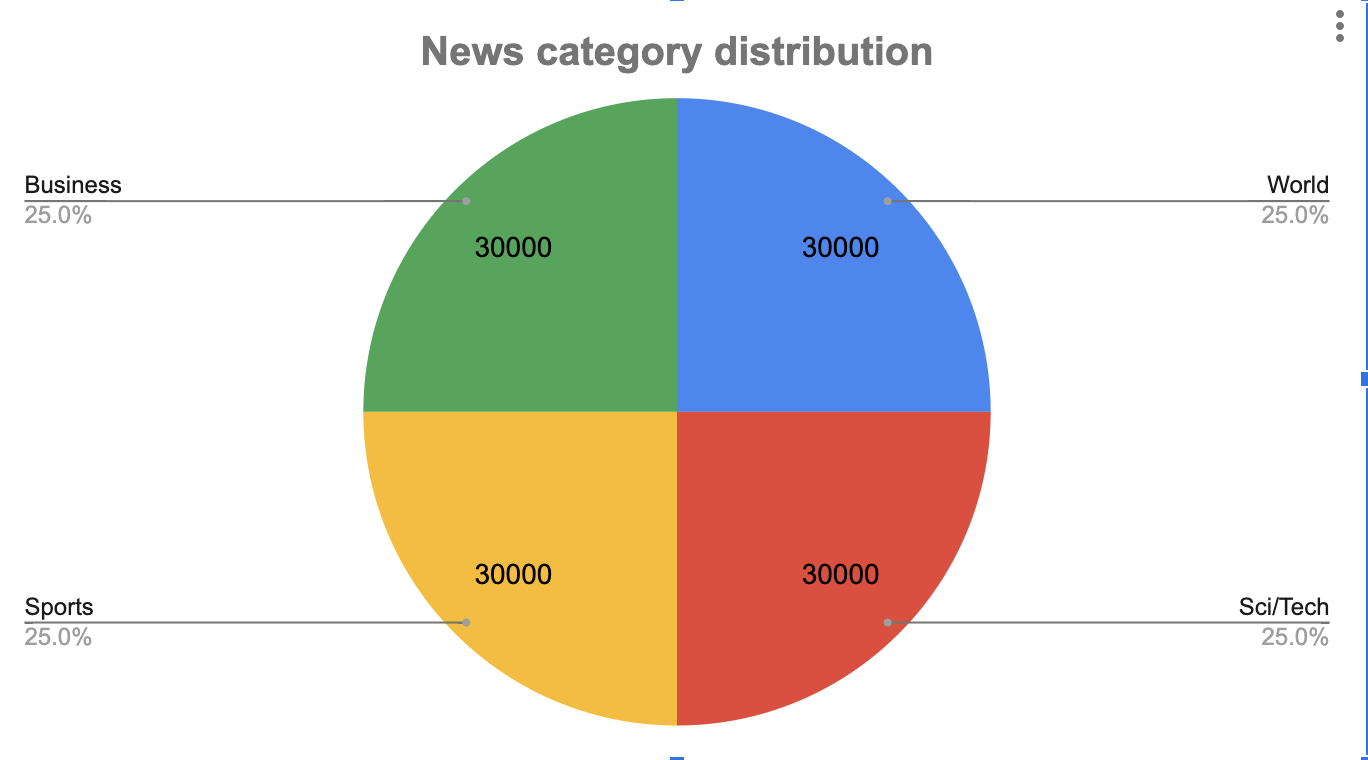

# Counting sum of all texts

In [ ]:
df.\
orderBy(col("text_length").desc()).\
groupBy('label').\
agg(
    (round( sum('text_length'), 3)).alias("sum_text_len")
    ).\
orderBy(col("sum_text_len").desc()).show()

+--------+------------+
|   label|sum_text_len|
+--------+------------+
|   World|     7253109|
|Business|     7133620|
|Sci/Tech|     7001483|
|  Sports|     6761535|
+--------+------------+



# The World category has the longest news article texts overall, while the Sports category has the shortest ones.
# 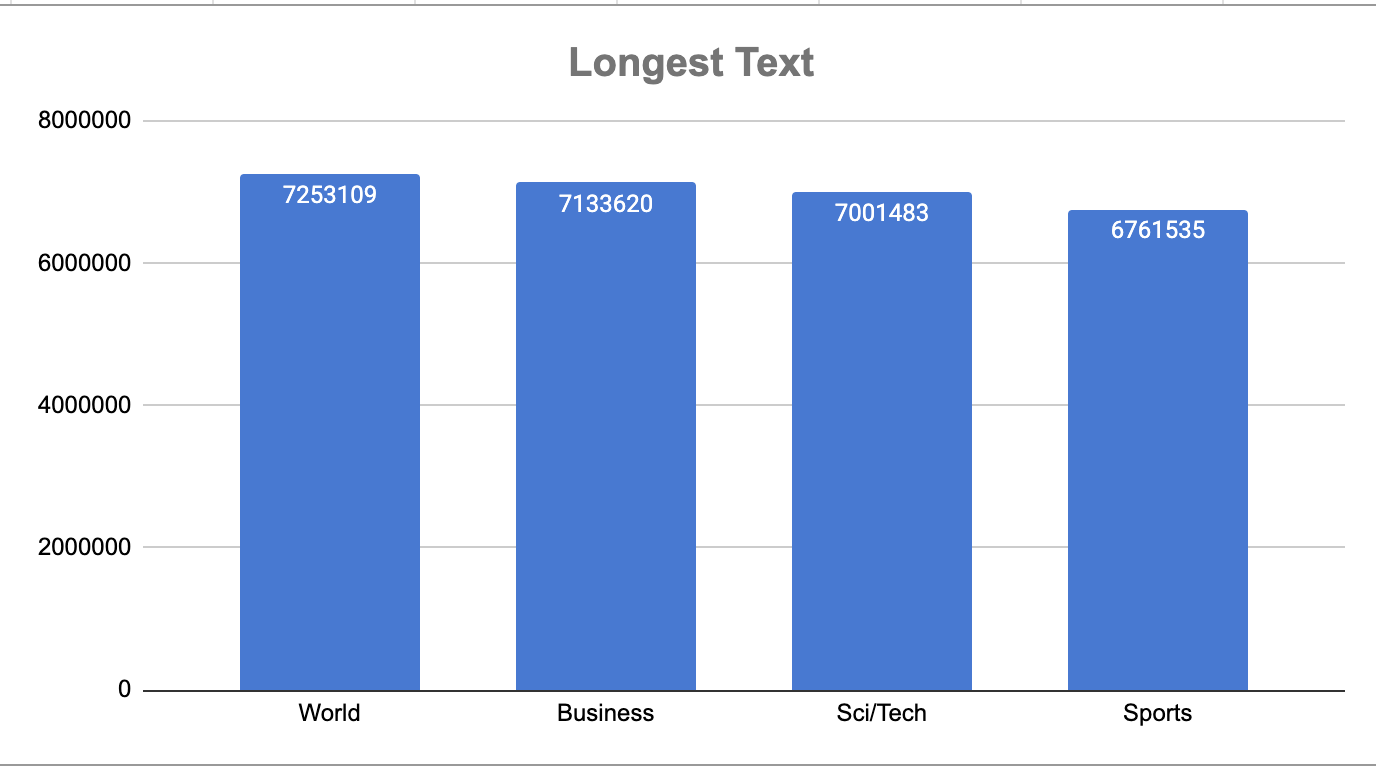

# Querying the average lenght of each article per category
It is logical that if the there are equal amount 30k articles for each category and the "World" has the most amount of text in it, it would also have the highest average length per article, but let's see what interesting we can find.

In [ ]:
df.\
orderBy(col("text_length").desc()).\
groupBy('label').\
agg(
    (round( avg('text_length'), 3)).alias("avg_all_text_len"),
    ).\
orderBy(col("avg_all_text_len").desc()).show()

+--------+----------------+
|   label|avg_all_text_len|
+--------+----------------+
|   World|          241.77|
|Business|         237.787|
|Sci/Tech|         233.383|
|  Sports|         225.385|
+--------+----------------+



# We see that similarly to overall text lenghts, the World category has the longest articles on Average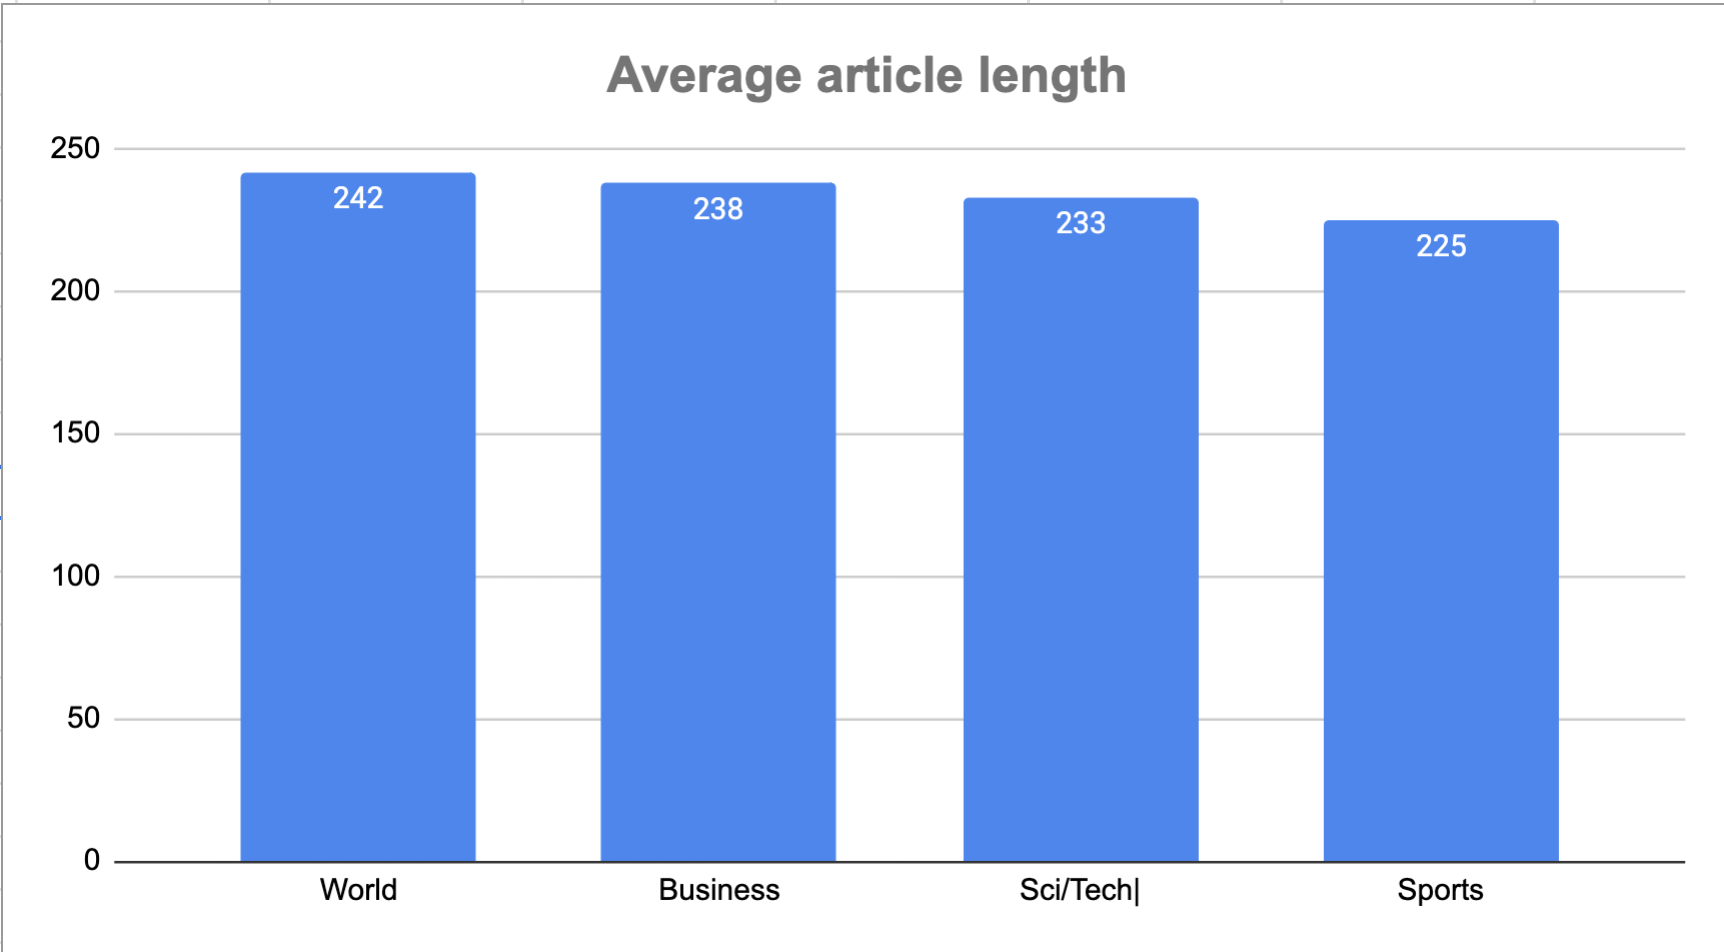

# Spliting each news into Titles and actua news body content to see what interesting we can get, as some can have longer titles shorter articles or vice-versa

In [ ]:
df.\
orderBy(col("text_length").desc()).\
groupBy('label').\
agg(
    (round( avg('body_text_len'), 0)).alias("avg_text_body_len"),
     (round( avg('title_len'), 0)).alias("avg_text_title_len"),
    ).\
orderBy(col("avg_text_body_len").desc()).show()

+--------+-----------------+------------------+
|   label|avg_text_body_len|avg_text_title_len|
+--------+-----------------+------------------+
|   World|            194.0|              46.0|
|Business|            194.0|              42.0|
|Sci/Tech|            189.0|              42.0|
|  Sports|            185.0|              38.0|
+--------+-----------------+------------------+



# 1. World And Business Articles on both average have 194 characters length for the news content but World articles just have longer titles compared to Business 46 vs 42.

# 2. News Titles of Business and Sci/Tech have the same title Lengths (42 characters) but actual content length for Business is more 194 vs 189.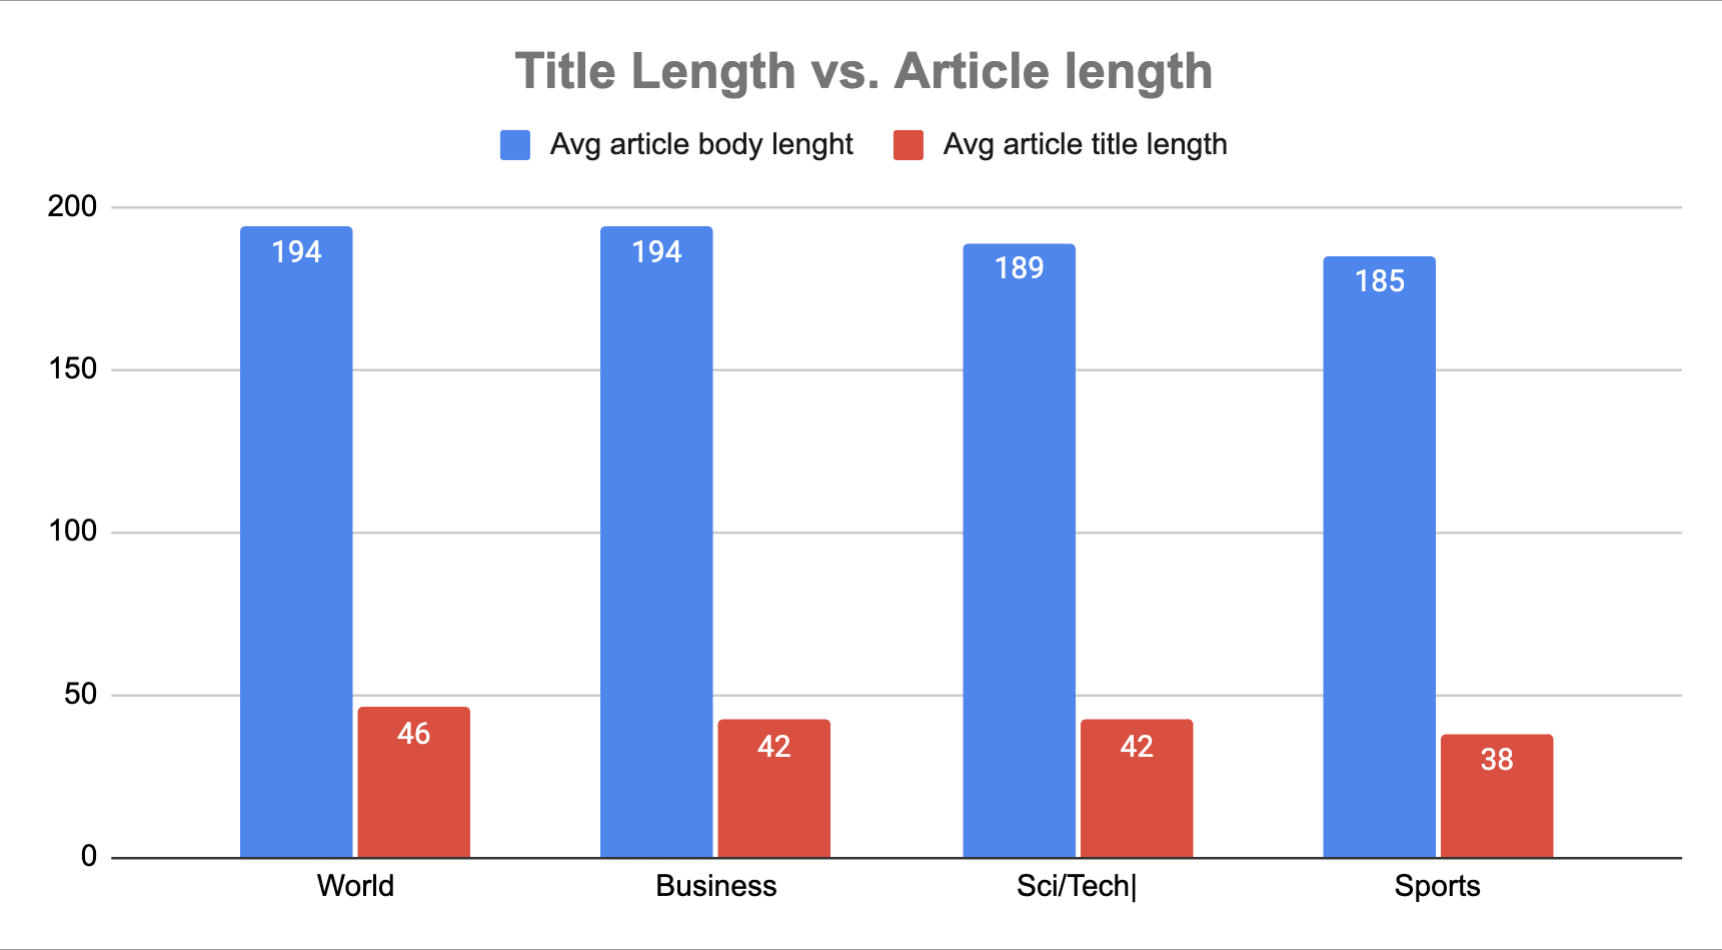

In [ ]:
df.\
orderBy(col("text_length").desc()).\
groupBy('label').\
agg(
    (round( avg('text_length'), 3)).alias("avg_all_text_len"),
     (round( avg('title_len'), 3)).alias("avg_text_title_len"),
    (round( avg('body_text_len'), 3)).alias("avg_text_body_len"),
    # (round( median('text_length'), 3)).alias("median_text_len"),
    (round( sum('text_length'), 3)).alias("sum_text_len")
    ).\
orderBy(col("avg_all_text_len").desc()).show()

+--------+----------------+------------------+-----------------+------------+
|   label|avg_all_text_len|avg_text_title_len|avg_text_body_len|sum_text_len|
+--------+----------------+------------------+-----------------+------------+
|   World|          241.77|            45.735|          194.035|     7253109|
|Business|         237.787|             41.72|          194.068|     7133620|
|Sci/Tech|         233.383|            42.373|          189.009|     7001483|
|  Sports|         225.385|            38.481|          184.903|     6761535|
+--------+----------------+------------------+-----------------+------------+



# 8 out of 10 from most repeated titles are from the Sports.If we were running marketing campaigns we could use this info to attract readers of this segment.

In [ ]:
df.\
orderBy(col("text_length").desc()).\
groupBy('label', "news_title").\
agg(  count("label").alias("title_count")
    ).\
orderBy(col("title_count").desc()).show(15, truncate=False )

+--------+-------------------------------------------+-----------+
|label   |news_title                                 |title_count|
+--------+-------------------------------------------+-----------+
|Sports  |Today's schedule                           |39         |
|Sports  |Transactions                               |39         |
|Sports  |SI.com                                     |34         |
|Sci/Tech|Enter your e-mail:                         |32         |
|Sports  |NL notables                                |19         |
|Sci/Tech|Search Engine Forums Spotlight             |18         |
|Sports  |SportsNetwork Game Preview                 |15         |
|Sports  |Baseball Today (AP)                        |14         |
|Sports  |Notables                                   |11         |
|Sports  |AL notables                                |11         |
|Sports  |This weekend on TV, radio                  |10         |
|Business|The Fool's Look Ahead                      |9       

# The most frequent title "Today's Schedule" talks about baseball, basketball, racing, hockey sports and their schedules. The second most frequent  title "Transactions" is mostly about baseball transactions and Contracts.


In [ ]:
df.\
filter(col("news_title").contains("Today's schedule")).show(40, truncate=False)

df.\
filter(col("news_title").contains("Transactions")).show(40, truncate=False)

+------+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------+-------------+
|label |news_title      |news_text    

In [ ]:
df.show(100)

+--------+--------------------+--------------------+--------------------+-----------+---------+-------------+
|   label|          news_title|           news_text|            all_text|text_length|title_len|body_text_len|
+--------+--------------------+--------------------+--------------------+-----------+---------+-------------+
|Business|Wall St. Bears Cl...|Reuters - Short-s...|Wall St. Bears Cl...|        145|       49|           94|
|Business|Carlyle Looks Tow...|Reuters - Private...|Carlyle Looks Tow...|        267|       51|          214|
|Business|Oil and Economy C...|Reuters - Soaring...|Oil and Economy C...|        233|       47|          184|
|Business|Iraq Halts Oil Ex...|Reuters - Authori...|Iraq Halts Oil Ex...|        257|       60|          195|
|Business|Oil prices soar t...|AFP - Tearaway wo...|Oil prices soar t...|        235|       73|          160|
|Business|Stocks End Up, Bu...|Reuters - Stocks ...|Stocks End Up, Bu...|        240|       43|          195|
|Business|

# **Part 2 A/B Test Design for News Content UI**

---




# **1.Hypothesis**
**Null Hypothesis:** The Order of news categories (e.g., World, Sports, Business, Tech) on the platform has no significant impact on user CTR. The CTR is 40%

**Alternative Hypothesis:** By Reordering the the news categories as World1, Sports1, Business1, Tech1 OR group them as World1, World2, World3 followed by Sports1, Sports2, Sports3 we will increase CTR rate by at least 0.8%
 percentage points.

##**2. Metrics**
**Primary Metric:** Click through rate (CTR)

**Secondary Metric:** Average Session duration (in seconds)



# 3.**Segmentation**

In [ ]:
#We need to randomly split data into original and test variants
#It is not likely that by splitting it randomly we the segments inside it would be split unequally
#But to be safe I will Split each news category separately then Union to original and varian1 to avoid unequal splitting of segments


#Let's split the data equally for each segment we have.
segments_list = ["World", "Sci/Tech", "Sports", "Business"]

# empty lists for appending the dataframes
original_dfs = []
variant1_dfs = []

# Filter each segment, and split them randomly
for segment in segments_list:
  #filtering each df by news category
  current_segment = df.filter(col("label")== segment)
  # splitting into original and variant 1 the news category and appending to lists
  temp_df1, temp_df2 = current_segment.randomSplit([0.5, 0.5], seed=42)
  original_dfs.append(temp_df1)
  variant1_dfs.append(temp_df2)

# Take the first df for unioning
# do 1 for original
original_df_combined =  original_dfs[0]
for tmp_df in original_dfs[1:]:
  original_df_combined = original_df_combined.union(tmp_df)


# repeat the same for variant 1
variant1_df_combined = variant1_dfs[0]
for tmp_df in variant1_dfs[1:]:
  variant1_df_combined = variant1_df_combined.union(tmp_df)


original_df_combined.\
groupBy('label').count().show()

variant1_df_combined.\
groupBy('label').count().show()

+--------+-----+
|   label|count|
+--------+-----+
|   World|15086|
|Sci/Tech|15092|
|  Sports|15128|
|Business|15127|
+--------+-----+

+--------+-----+
|   label|count|
+--------+-----+
|   World|14914|
|Sci/Tech|14908|
|  Sports|14872|
|Business|14873|
+--------+-----+



#**4.** **Methodology**


1.First let's see how much sample we would need for running this experiment

In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportion_effectsize
import statsmodels.stats.power as smp

NormalIndPower = smp.NormalIndPower


from statsmodels.stats.proportion import proportion_effectsize
def calculate_sample_size(baseline_conversion, min_detectable_effect, alpha=0.05, power=0.8):
    """
    Calculate the required sample size for an A/B test given a baseline conversion rate,
    minimum detectable effect, significance level, and desired power.
    Args:
    baseline_conversion (float): Baseline conversion rate.
    min_detectable_effect (float): Minimum detectable effect.
    alpha (float, optional): Significance level. Default is 0.05.
    power (float, optional): Desired power. Default is 0.8.

    Returns:
    int: Required sample size per group.
    """
    effect_size = proportion_effectsize(baseline_conversion, baseline_conversion + min_detectable_effect)
    sample_size = NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1)
    return np.ceil(sample_size)
# In
baseline_conversion = 0.40  # 10% conversion rate
min_detectable_effect = 0.008  # Want to detect a 2% increase
alpha = 0.05  # 5% significance level
power = 0.8  # 80% power

sample_size = calculate_sample_size(baseline_conversion, min_detectable_effect, alpha, power)
print(f"To see {min_detectable_effect*100}% points change from {baseline_conversion*100}%\
      the Required sample size per group is: {sample_size}")

To see 0.8% points change from 40.0%      the Required sample size per group is: 59058.0


# Let's Ssume that we have daily 10k samples each day so in order to gather 59058 samples per variant we need to wait 12 days for this test . having from each variant 5k traffic.

# Let's assume that we 12 days passed and we are checking the results of the experiment and wee see that each variants have 60000 rows of enough sample to check the resutls.

# The Results in Original variant we have the same 40% CTR% which is 24000 click While in variant1 there are 24580 clicks. 0.96% points increase, that's more than the expected 0.8% Excellent let's check if the change is statistically significant.

# To measure it we need to do proportion z-test for one tail only as in our hypothesis we needed see only a positive change which is only in one direction.

In [ ]:

import numpy as np
from statsmodels.stats.proportion import proportions_ztest

count = np.array([24000, 24480])
nobs = np.array([60000, 60000])
stat, pval = proportions_ztest(count, nobs)
pvalue = np.round(pval/2, 3)


if pvalue <= 1-95/100:
  print(pvalue,"is_significant")
else:
  print(pvalue, 'not_significant')

# Source https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html

0.002 is_significant


# We see that the change is a significant

# Analysing The Secondary Metric, Average session duration

In [63]:
import numpy as np
from scipy.stats import ttest_ind
# Let's Generate some Average session duration data per seconds for 12 days

np.random.seed(0)  # for reproducibility

original_group = np.random.normal(120, 10, 12)  # mean=120, std deviation=10, 12 samples
variant1_group = np.random.normal(135, 10, 12)  # mean=135, std deviation=10, 12 samples

t_stat, p_value = ttest_ind(original_group, variant1_group, alternative="less")

alpha = 0.05
if p_value < alpha:
    print(f"Reject the null hypothesis. p-value = {p_value:.4f}")
else:
    print(f"Fail to reject the null hypothesis. p-value = {p_value:.4f}")


-1.951284351484132 0.031935868633629697
Reject the null hypothesis. p-value = 0.0319


We see that average session durations increased significantly from 120 seconds to 135 seconds.

# Finaly Summary
 **Description:** We had an experiment of reordering news categories with a goal to increase the CTR% from 40% with at least 0.8%percentage points. To run this experiment we needed 60000 samples for each variant, and we run it 12 days to have enough traffic.

 **Analysis** We saw significant increase in CTR% with 0.96% percentage points and also and increase in Avg Session Duration with 15 seconds which is also significant.

 **Conclusion** The experiment goal is achieved and we could also manage to have a positive impact on secondary metric, therefore I recommend to release the variant1 to live.

**Final comments** about the a/b problem. Of course it is not realistic to make a 0.8% increase and increase the session duration so by so much. I don't think there exist such a corellation in CTR and Duration anywhere, but i tried to create the scenarion where I have to use both proportion ztest and T-test for continues data.

# The Bonus task Classification

In [5]:
df.show()

+--------+--------------------+--------------------+--------------------+-----------+---------+-------------+
|   label|          news_title|           news_text|            all_text|text_length|title_len|body_text_len|
+--------+--------------------+--------------------+--------------------+-----------+---------+-------------+
|Business|Wall St. Bears Cl...|Reuters - Short-s...|Wall St. Bears Cl...|        145|       49|           94|
|Business|Carlyle Looks Tow...|Reuters - Private...|Carlyle Looks Tow...|        267|       51|          214|
|Business|Oil and Economy C...|Reuters - Soaring...|Oil and Economy C...|        233|       47|          184|
|Business|Iraq Halts Oil Ex...|Reuters - Authori...|Iraq Halts Oil Ex...|        257|       60|          195|
|Business|Oil prices soar t...|AFP - Tearaway wo...|Oil prices soar t...|        235|       73|          160|
|Business|Stocks End Up, Bu...|Reuters - Stocks ...|Stocks End Up, Bu...|        240|       43|          195|
|Business|

In [1]:
import pandas as pd

# Read the CSV file into a Pandas DataFrame
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

,3,Fears for T N pension after talks,Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
0,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
1,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
2,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
3,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
4,4,Open Letter Against British Copyright Indoctri...,The British Department for Education and Skill...
...,...,...,...
7594,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7595,2,Void is filled with Clement,With the supply of attractive pitching options...
7596,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7597,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


# Preparing the test dataframe

In [26]:
df_test = spark.read.csv("test.csv", header=False, inferSchema=True)
df_train = spark.read.csv("train.csv", header=False, inferSchema=True)

df_test = df_test.withColumnRenamed('_c0', "label").\
      withColumnRenamed("_c1", "news_title").\
      withColumnRenamed("_c2", "news_text").\
      withColumn("all_text", concat_ws(", ","news_title",'news_text')).\
      select(col("label"), col("all_text")).toPandas()


df_train = df_train.withColumnRenamed('_c0', "label").\
      withColumnRenamed("_c1", "news_title").\
      withColumnRenamed("_c2", "news_text").\
       withColumn("all_text", concat_ws(", ","news_title",'news_text')).\
      select(col("label"), col("all_text")).toPandas()




In [30]:
X_train, X_test, y_train, y_test = df_train['all_text'], df_test['all_text'], df_train['label'], df_test['label']

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Converting text data into TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

In [41]:
# The solver parameter is set to 'lbfgs', which is an optimization algorithm in the
# family of quasi-Newton methods that's appropriate for multinomial logistic regression.
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train_tf, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [42]:
y_pred = clf.predict(X_test_tf)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9163157894736842
              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.89      0.88      0.88      1900
           4       0.89      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600

